# Грузим библиотеки

In [1]:
from flask import Flask
from flask import request
import requests
from flask import make_response
import os
import json
from pandas import DataFrame
import traceback


from methods import access
from methods.emoji import emoji
from methods import telegram_bot_methods
from methods import google_maps_methods
from methods import psql_methods
from methods import reply
from dicts import dict_dates



import app



if __name__ == "__main__":

    
    app.application.run()



In [2]:
X = {'update_id': 201011794, 'message': {'message_id': 159, 'from': {'id': 84723474, 'first_name': 'Александр', 'last_name': 'Толмачёв', 'language_code': 'ru-RU'}, 'chat': {'id': 84723474, 'first_name': 'Александр', 'last_name': 'Толмачёв', 'type': 'private'}, 'date': 1502611993, 'text': '/help', 'entities': [{'type': 'bot_command', 'offset': 0, 'length': 5}]}}
X['message']['text'] = '/start'
X['message']['chat']['last_name']

'Толмачёв'

In [3]:
#тест отправки графика
import psycopg2
from pandas import DataFrame
import pandas as pd
from datetime import datetime
from datetime import timedelta

import numpy as np

#текущая метка времени
def now_str():
    now = datetime.now()
    now_str = str(now.year)+str(now.month if now.month >= 10 else  '0'+str(now.month))+str(now.day if now.day >= 10 else  '0'+str(now.day)) +' '+str(now.hour if now.hour >= 10 else  '0'+str(now.hour)) + str(now.minute if now.minute >= 10 else  '0'+str(now.minute)) + str(now.second if now.second >= 10 else  '0'+str(now.second))
    return now_str


dbname = 'dbr3jigs1op5oo'
port = '5432'
user = 'muwrkppfuyldmk'
host = 'ec2-54-227-252-202.compute-1.amazonaws.com'
password = '4c4eabfcaf92f7289ccfc1a314d04a3c3806db72b1bf12fd5f0f40c410b14355'

PSQL_heroku_keys = {'dbname' : dbname
                    , 'port' : port
                    , 'user' : user
                    , 'host' : host
                    , 'password' : password
                    }


conn = psycopg2.connect("dbname='%(dbname)s' port='%(port)s' user='%(user)s' host='%(host)s' password='%(password)s'" % PSQL_heroku_keys)


# создаем запрос
cur = conn.cursor()

user_id = 13

cur.execute("select * from public.tasks where  user_id = %(user_id)s " % {  'user_id' : user_id} )

df_plan_tasks = DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description]).sort_values(by='date_task' , ascending=True)

cur.close() 


ok


,id,user_id,family_id,task,date_task,flg_done
1,2,13,None,Позвонить папе по поводу лоджии,2017-09-24,False
3,4,13,None,тестовые дела,2017-09-26,False
4,5,13,None,Позвонить Николаю узнать контакты Виталия,2017-09-26,False
5,6,13,None,Грише документы отправить,2017-09-26,False
6,7,13,None,Позвонить секретарю в суд о предварительном ре...,2017-09-26,False
7,8,13,None,Изучить ошибки у Марины в боте,2017-09-27,False
8,9,13,None,Составить хадатайство для суда.,2017-09-27,False
0,1,13,None,Планируем ли дела делишечки?,2017-10-01,False
11,12,13,None,Встреча с Шестаковым в 16:00,2017-10-02,False
12,13,13,None,Скопировать видео сми,2017-10-02,False


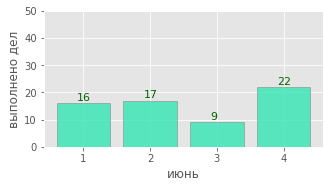

In [66]:
### make good

#формируем ответ
response = {'status' : 200
            ,'report' : 'prev_month_complete_tasks'
            ,'message' : 'No reports'
            }

# создаем запрос
cur = conn.cursor()
#смотрим, какие данные завтра есть
cur.execute("select * from public.tasks where date_task >= date_trunc('month',now()) - INTERVAL '1MONTH' and date_task < date_trunc('month',now())")

#получаем данные
df_prev_month_tasks = DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])


if df_prev_month_tasks.shape[0] == 0:
    cur.close()
    #return response
else:
    cur.execute("select id , chat_id from public.user" )
    df_user = DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
    cur.close()
    
#подгатавливаем лист с сообщениями
list_messages = []
#делаем выборку из пользователей, по кому нужно направить ответ
list_user_id = list(df_prev_month_tasks['user_id'].unique())
df_user_id = df_user[df_user.id.isin(list_user_id)][:]

#нумеруем недели для составления отчетов
df_prev_month_tasks['n_week'] = [int(x.day / 7) + 1 for x in df_prev_month_tasks['date_task']]

#получаем месяц, за который составляем отчет
month_num_to_names = dict_dates.month_num_to_names
prev_month = df_prev_month_tasks.date_task[0].month
prev_month = month_num_to_names[prev_month]


#проходим по ним и заполняем листр завтрашних плановых операций
for i,row in df_user_id.iterrows():
    #получаем данные пользователя
    user_id = row.id
    chat_id = row.chat_id
    #получаем данные по определенному пользователю
    interest_info = df_prev_month_tasks[(df_prev_month_tasks.user_id == user_id)][:]
    
    #формируем серию с нужными данными для составления отчета
    res = interest_info.groupby(['n_week'])['id'].count()
    
    #формируем отчет
    cnt_missions = res.values
    name_bars = list(res.index)
    y_pos = np.arange(len(name_bars))

    plt.figure(figsize=(5,2.5))
    plt.bar(y_pos, cnt_missions, color = (0.2, 0.9, 0.7, 0.8) ,  edgecolor='gray')

    plt.xlabel(prev_month)
    plt.ylabel('выполнено дел')
    plt.ylim(0,50)
    plt.xticks(y_pos, name_bars)

    for a,b in zip(y_pos, cnt_missions): 
        plt.text(a - 0.1, b + 1, str(b) , fontsize=11 , color = 'darkgreen')

    
    #сохраняем картинки по отчетам
    path = './images/prev_month_complete_tasks/'
    full_path = path+str(user_id)+'.png'
    plt.savefig(full_path ,facecolor='w', edgecolor='w')

    plt.show()
    plt.close()
    
    #формируем текст для отчетика
    all_month_tasks = sum(res.values)
    text = 'Поглядим поглядим, %s сделано. Молодец, работай над собой!' % all_month_tasks
    
    #формируем итоговый словарь по пользователю по ответу
    user_dict_tomorrow_messages = {'user_id' : user_id
                                  ,'chat_id' : chat_id
                                  ,'message' : text
                                  ,'photo_path' : full_path}
    #добавляем инфо в общей список сообщений
    list_messages.append(user_dict_tomorrow_messages)
    
#заполняем информацию по ответу
response['system_message'] = 'Have reports'
response['user_messages'] = list_messages
